# Download data from Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 30K dataset
# !kaggle datasets download -d hsankesara/flickr-image-dataset

# 8K dataset
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:14<00:00, 67.6MB/s]
100% 1.04G/1.04G [00:15<00:00, 74.1MB/s]


In [ ]:
# !unzip -o /content/flickr-image-dataset.zip
!unzip -o /content/flickr8k.zip

In [ ]:
# !rm /content/flickr-image-dataset.zip
!rm /content/flickr8k.zip

In [ ]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/646Project/Data/'
path = '/content/'

# Split data into training set and test set

In [ ]:
import pandas as pd
import numpy as np

## Split only once

In [ ]:
path = '/content/'
captions = pd.read_csv(path + 'captions.txt',delimiter=",")

In [ ]:
img_names = captions['image'].drop_duplicates()

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs = train_test_split(img_names, test_size=0.15)

In [ ]:
train = captions.loc[captions['image'].isin(train_imgs)]
test = captions.loc[captions['image'].isin(test_imgs)]

In [ ]:
train.to_csv(drive_path + 'captions_train.csv', index=False)
test.to_csv(drive_path + 'captions_test.csv', index=False)

## Load previously split pattern

In [ ]:
train = pd.read_csv(drive_path + 'captions_train.csv')
test = pd.read_csv(drive_path + 'captions_test.csv')

In [ ]:
import os

os.makedirs(path + 'flickr8K/train', exist_ok=True)
os.makedirs(path + 'flickr8K/test', exist_ok=True)

In [ ]:
import shutil

# move training data
for img_path in set(train['image']):
    src = os.path.join(path + 'Images/', img_path)
    dst = os.path.join(path + 'flickr8K/train', img_path)
    shutil.move(src, dst)

In [ ]:
import shutil

# move test data
for img_path in set(test['image']):
    src = os.path.join(path + 'Images/', img_path)
    dst = os.path.join(path + 'flickr8K/test', img_path)
    shutil.move(src, dst)

# Get classes from text

In [ ]:
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
path = '/content/'
results = pd.read_csv(path + 'captions_train.csv',delimiter=",")

In [ ]:
results.head()

,image,caption
0,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
2,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
3,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
4,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [ ]:
captions = results[results.columns[-1]].tolist()

In [ ]:
len(captions)

34385

## Sample of extract nouns from text

In [ ]:
captions[0]

'A black dog and a spotted dog are fighting'

In [ ]:
lines = captions[0]
# function to test if something is a noun
is_noun = lambda pos: pos[:2] == 'NN'

# remove stop words
stop_words = set(stopwords.words('english'))
lines = [i for i in word_tokenize(lines.lower()) if i not in stop_words] 

# lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
lines = [wordnet_lemmatizer.lemmatize(w) for w in lines]
nouns = [word for (word, pos) in nltk.pos_tag(lines) if is_noun(pos)] 

print(lines)
print(nouns)

['black', 'dog', 'spotted', 'dog', 'fighting']
['dog', 'dog', 'fighting']


## Extract different nouns from text as classes

In [ ]:
classes = dict()
is_noun = lambda pos: pos[:2] == 'NN'
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

for line in captions:
    line = [i for i in word_tokenize(str(line).lower()) if i not in stop_words] 
    line = [wordnet_lemmatizer.lemmatize(w) for w in line]
    nouns = [word.lower() for (word, pos) in nltk.pos_tag(line) if is_noun(pos)]
    for n in nouns:
        classes[n] = classes.get(n, 0) + 1

In [ ]:
print("Number of Classes:", len(classes))

Number of Classes: 4306


In [ ]:
classes = sorted(classes.items(), key=lambda item: item[1], reverse=True)

In [ ]:
df = pd.DataFrame(classes)
df = df.rename(columns={0: 'word', 1: 'freq'})

In [ ]:
df.head()

,word,freq
0,dog,8178
1,man,6144
2,woman,3381
3,boy,2846
4,girl,2593


In [ ]:
df.to_csv('classes.csv', index=False) 

# Zero-shot prediction using CLIP

In [ ]:
!pip install openai-clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368637 sha256=7f541b1c85ef5e6cc635f302141833acd4de0c79ec5afc9a480664585f31a719
  Stored in directory: /root/.cache/pip/wheels/ed/16/0c/1d8af7a12528df0e48743f4bc106808175e64a8b9efacbeb4b
Successfully built openai-clip


In [ ]:
import os
import clip
import torch
from PIL import Image
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
class Flickr8K(torch.utils.data.Dataset):
    def __init__(self, objects, chop_freq, transform=None, train=True):
        self.path = '/content/'

        if train:
            self.img_path = self.path + 'flickr8K/train/'
            results = pd.read_csv(path + 'captions_train.csv', delimiter=",")
        else:
            self.img_path = self.path + 'flickr8K/test/'
            results = pd.read_csv(path + 'captions_test.csv', delimiter=",")
        results = results.dropna()
        self.img_names = results['image'].drop_duplicates().tolist()
        self.captions = results
        # only use frequently occurred words as classes
        self.objects = objects[objects['freq'] > chop_freq]['word'].to_list()
        
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.img_path + self.img_names[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        captions = self.captions[self.captions['image'] == self.img_names[idx]]['caption'].tolist()
        return self.img_names[idx], image, captions

    def __len__(self):
        return len(self.img_names)

## Show some samples of data

In [ ]:
objects = pd.read_csv(drive_path + 'classes.csv')
flickr = Flickr8K(objects=objects, chop_freq=100, train=True)

1000268201_693b08cb0e.jpg


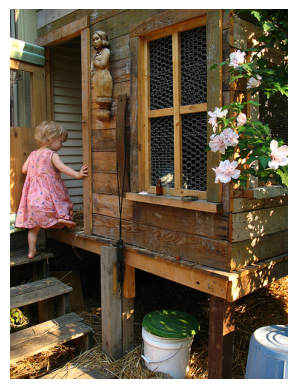

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [ ]:
img_name, img, caps = flickr[0]
print(img_name)
plt.imshow(img)
plt.axis(False)
plt.show()
for cap in caps:
    print(cap)

## Zero-shot object detection: CLIP

In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 91.4MiB/s]


In [ ]:
classes = pd.read_csv(drive_path + 'classes.csv')
flickr = Flickr8K(objects=classes, chop_freq=100, train=False)

In [ ]:
len(flickr.objects)

186

In [ ]:
top_obj = 20
obj_lists = {}

for i in range(len(flickr)):
    # Prepare the inputs
    img_name, image, captions = flickr[i]
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"There is {c} in the photo") for c in flickr.objects]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Pick the top most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(top_obj)

    objs = []
    for index in indices:
        objs.append(flickr.objects[index])
    obj_lists[img_name] = objs

    if i % 100 == 0:
        print('Finished processing %d imgs' % i)

Finished processing 0 imgs
Finished processing 100 imgs
Finished processing 200 imgs
Finished processing 300 imgs
Finished processing 400 imgs
Finished processing 500 imgs
Finished processing 600 imgs
Finished processing 700 imgs
Finished processing 800 imgs
Finished processing 900 imgs
Finished processing 1000 imgs
Finished processing 1100 imgs
Finished processing 1200 imgs


In [ ]:
objs_df = pd.DataFrame(obj_lists)

In [ ]:
objs_df.to_csv(drive_path + 'CLIP_obj_lists_test.csv', index=False)

# Generate image caption: FLAN-T5

In [ ]:
!pip -q install transformers==4.26.0
!pip -q install sentencepiece
!pip -q install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 18.0 MB/s eta 0:00:00


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-XL")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-XL", device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
obj_lists = pd.read_csv(drive_path + 'CLIP_obj_lists_test.csv')

## FLAN-T5-Small / FLAN-T5-XL

In [ ]:
t5_captions = {}
cnt = 0

for (img_path, objs) in obj_lists.items():
    input_text = 'Generate an image caption from the object lists: '
    obj_list = objs.tolist()
    
    obj_str = ', '.join(obj_list)
    input_text += obj_str

    # print(input_text)
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
    generate_captions = []
    for i in range(5):
        outputs = model.generate(input_ids, 
                                 num_beams = 5, 
                                 do_sample = True,
                                 temperature=0.9, 
                                 max_new_tokens = 30, 
                                 output_scores = True, 
                                 return_dict_in_generate = True)
        generate_caption = tokenizer.decode(outputs.sequences[0])
        generate_captions.append(generate_caption)
    # print(input_text)
    t5_captions[img_path] = generate_captions

    cnt += 1

    if cnt % 100 == 0:
        t5_captions_df = pd.DataFrame(t5_captions)
        t5_captions_df.to_csv(drive_path + 'T5XL_captions.csv', index=False)
        print('Finish processing %d/%d' % (cnt, len(obj_lists.columns)))
        # break

t5_captions_df = pd.DataFrame(t5_captions)
t5_captions_df.to_csv(drive_path + 'T5XL_captions.csv', index=False)

Finish processing 100/1214
Finish processing 200/1214
Finish processing 300/1214
Finish processing 400/1214
Finish processing 500/1214
Finish processing 600/1214
Finish processing 700/1214
Finish processing 800/1214
Finish processing 900/1214
Finish processing 1000/1214
Finish processing 1100/1214
Finish processing 1200/1214


In [ ]:
t5_captions_df

,1002674143_1b742ab4b8.jpg,1007320043_627395c3d8.jpg,1030985833_b0902ea560.jpg,1056338697_4f7d7ce270.jpg,1056873310_49c665eb22.jpg,1057089366_ca83da0877.jpg,1075867198_27ca2e7efe.jpg,1075881101_d55c46bece.jpg,10815824_2997e03d76.jpg,1082252566_8c79beef93.jpg,...,93922153_8d831f7f01.jpg,94232465_a135df2711.jpg,944374205_fd3e69bfca.jpg,953941506_5082c9160c.jpg,963730324_0638534227.jpg,97105139_fae46fe8ef.jpg,973827791_467d83986e.jpg,974924582_10bed89b8d.jpg,97731718_eb7ba71fd3.jpg,985067019_705fe4a4cc.jpg
0,<pad> A toddler is playing on a swing in a yar...,<pad> A boy and a girl are playing in a playgr...,<pad> A group of dogs are chasing a ball in a ...,<pad> A group of people are running down the s...,<pad> A greyhound dog is playing with a ball o...,<pad> a skateboarder catches a frisbee midair</s>,<pad> A greyhound dog is playing catch with a ...,<pad> A toddler is playing with a ball in the ...,<pad> A group of people are outdoors chasing a...,<pad> group of dogs playing outdoors with a gr...,...,<pad> A couple of climbers are outdoors on a c...,<pad> A toddler is playing in the snow with an...,<pad> group of kids playing soccer in a field</s>,<pad> A greyhound dog is walking on a leash on...,<pad> A toddler is playing with a toy on the f...,<pad> A group of people are playing a game of ...,<pad> A toddler is playing with a frisbee in a...,<pad> A group of kids are playing frisbee in t...,<pad> A group of people holding hockey sticks ...,<pad> A toddler is playing on a swing at a pla...
1,<pad> A toddler is playing with a toy on a swi...,<pad> A group of kids playing in a playground ...,<pad> A group of greyhounds chase a ball in a ...,<pad> A group of people are racing down a stre...,<pad> A greyhound dog is playing with a ball o...,<pad> A skateboarder is jumping into a pool.</s>,<pad> A dog is playing catch with a frisbee.</s>,<pad> A girl holds a baby boy's hand as he pla...,<pad> A woman is chasing a man on a horse thro...,<pad> A group of greyhounds are playing in a y...,...,<pad> A couple of climbers are outdoors on a r...,<pad> A toddler is playing in the snow with a ...,<pad> group of kids playing soccer in a field</s>,<pad> A greyhound dog is walking on a leash on...,<pad> A toddler is playing with a toy on the f...,<pad> A group of people are playing in the san...,<pad> A toddler is playing with a frisbee in a...,<pad> A toddler is chasing a frisbee in a play...,<pad> A group of people holding hockey sticks ...,<pad> A group of kids playing on a playground ...
2,<pad> A toddler is playing on a swing in a yar...,<pad> A group of kids playing in a playground ...,<pad> A group of greyhounds chase a frisbee in...,<pad> A group of people are running down the s...,<pad> A greyhound dog is playing with a ball o...,<pad> a skateboarder jumps into the air and ca...,<pad> A dog is playing catch with a frisbee on...,<pad> A toddler is playing with a basketball.</s>,<pad> A group of people are outdoors chasing a...,<pad> group of dogs playing outdoors with a gr...,...,<pad> A couple of climbers are outdoors climbi...,<pad> A child is playing in the snow with a le...,<pad> group of kids playing soccer outdoors in...,<pad> A greyhound dog is walking on a leash on...,<pad> A toddler is playing with a toy on the f...,<pad> A group of people are playing in the san...,<pad> A toddler is playing with a frisbee in a...,<pad> A kid is chasing a frisbee in the yard.</s>,<pad> A group of people are playing hockey on ...,<pad> A toddler is playing on a swing at a pla...
3,<pad> A toddler is playing on a swing in a gra...,<pad> A boy and a girl are playing in a playgr...,<pad> A group of greyhounds chase a frisbee in...,<pad> A group of bikers are racing down a stre...,<pad> A greyhound dog is playing on the beach ...,<pad> A skateboarder is jumping in the air.</s>,<pad> A dog is playing catch with a frisbee on...,<pad> A toddler is playing with a ball in the ...,<pad> A group of people are outdoors chasing a...,<pad> group of dogs playi

# Select the best caption using CLIP

In [ ]:
!pip install openai-clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368637 sha256=d8fd07f572973306bcf23f8104482385b70fb3f3bba0241796025ef60e689dfc
  Stored in directory: /root/.cache/pip/wheels/ed/16/0c/1d8af7a12528df0e48743f4bc106808175e64a8b9efacbeb4b
Successfully built openai-clip


In [ ]:
import os
import clip
import torch
from PIL import Image
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 127MiB/s]


In [ ]:
captions_t5 = pd.read_csv(drive_path + 'T5Small_captions.csv')

In [ ]:
img_path = '/content/Images/'

In [ ]:
clip_captions = {}
cnt = 0

for (img_name, captions) in captions_t5.items():
    cnt += 1

    image = Image.open(img_path + img_name).convert('RGB')
    image_input = preprocess(image).unsqueeze(0).to(device)
    captions = captions.str.replace('<pad> ', '')
    captions = captions.str.replace('</s>', '')
    captions = captions.tolist()
    text_inputs = torch.cat([clip.tokenize(captions)]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Pick the top most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    clip_captions[img_name] = captions[index]

    if cnt % 100 == 0:
        print('Finished processing %d imgs' % cnt)

Finished processing 100 imgs
Finished processing 200 imgs
Finished processing 300 imgs
Finished processing 400 imgs
Finished processing 500 imgs
Finished processing 600 imgs
Finished processing 700 imgs
Finished processing 800 imgs
Finished processing 900 imgs
Finished processing 1000 imgs
Finished processing 1100 imgs
Finished processing 1200 imgs


In [ ]:
clip_captions_df = pd.DataFrame(clip_captions, index=[0])
clip_captions_df = clip_captions_df.transpose()
clip_captions_df.to_csv(drive_path + 'CLIP_Small_captions.csv')

# CLIP + GPT-2 Model

## Extract feature from image using CLIP model

In [ ]:
!pip install openai-clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368637 sha256=9ef9b63c1b9ed4f3fb580fe97688651342eb2f4977c66684916f84d69f5df352
  Stored in directory: /root/.cache/pip/wheels/ed/16/0c/1d8af7a12528df0e48743f4bc106808175e64a8b9efacbeb4b
Successfully built openai-clip


In [ ]:
import os
import clip
import torch
from PIL import Image
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage.io as io

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 67.5MiB/s]


In [ ]:
out_path = drive_path + 'flickr_image_feature_train.pkl'

In [ ]:
train_data = pd.read_csv(path + 'captions_train.csv')
print("%d captions loaded from training data " % len(train_data))

34385 captions loaded from training data 


In [ ]:
# exteact image feature using CLIP and save as a pkl file

all_embeddings = []
all_captions = []
img_embedding = {}
idx = 0
for img_name in tqdm(train_data['image'].drop_duplicates()):
    filename = path + 'flickr8K/train/' + img_name
    image = io.imread(filename)
    image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = clip_model.encode_image(image).cpu()
    img_embedding[img_name] = feature
    if (idx + 1) % 1000 == 0:
        with open(out_path, 'wb') as f:
            pickle.dump(img_embedding, f)
    idx += 1

100%|██████████| 6877/6877 [35:45<00:00,  3.21it/s]


In [ ]:
with open(out_path, 'wb') as f:
    pickle.dump(img_embedding, f)

In [ ]:
with open(out_path, 'rb') as f:
    clip_embeddings = pickle.load(f)

## Train CLIP and GPT-2 Model

In [ ]:
!pip install transformers

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import pandas as pd
from tqdm import tqdm
from PIL import Image

In [ ]:
class GPT2Flickr8K(torch.utils.data.Dataset):
    def __init__(self, img_length: int, img_feature_norm=False, transform=None, train=True):
        self.path = '/content/'

        if train:
            self.img_path = self.path + 'flickr8K/train/'
            results = pd.read_csv(drive_path + 'captions_train.csv', delimiter=",")
        else:
            self.img_path = self.path + 'flickr8K/test/'
            results = pd.read_csv(drive_path + 'captions_test.csv', delimiter=",")
        results = results.dropna()
        self.img_names = results['image'].tolist()
        self.captions = results['caption'].tolist()

        with open(drive_path + 'flickr_image_feature_train.pkl', 'rb') as f:
            self.clip_embeddings = pickle.load(f)
        
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.img_length = img_length
        self.img_feature_norm = img_feature_norm
        
        self.transform = transform

        if os.path.isfile(drive_path + "flickr_tokens_train.pkl"):
            with open(drive_path + "flickr_tokens_train.pkl", 'rb') as f:
                self.captions_tokens, self.max_seq_len = pickle.load(f)
        else:
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0
            for caption in self.captions:
                self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption), dtype=torch.int64))
                max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
            with open(drive_path + "flickr_tokens_train.pkl", 'wb') as f:
                pickle.dump([self.captions_tokens, max_seq_len], f)
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))

    def __getitem__(self, idx):
        tokens, mask = self.pad_tokens(idx)
        img_name = self.img_names[idx]
        img_feature = self.clip_embeddings[img_name]
        if self.img_feature_norm:
            img_feature = img_feature.float()
            img_feature = img_feature / img_feature.norm(2, -1)
        return tokens, mask, img_feature

    def __len__(self):
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.img_length), mask), dim=0)  # adding image-feature mask
        return tokens, mask

In [ ]:
from typing import Tuple
class Adapter(nn.Module):
    def forward(self, x):
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(Adapter, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)

In [ ]:
class ClipGPT2Model(nn.Module):
    def __init__(self, img_feature_length, img_feature_size = 512):
        super(ClipGPT2Model, self).__init__()
        self.img_feature_length = img_feature_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = Adapter((img_feature_size, 
                                       (self.gpt_embedding_size * img_feature_length) // 2, 
                                       self.gpt_embedding_size * img_feature_length))
        
    def get_dummy_token(self, 
                        batch_size: int, 
                        device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.img_feature_length, dtype=torch.int64, device=device)

    def forward(self, 
                tokens: torch.Tensor, 
                feature: torch.Tensor, 
                mask = None, 
                labels = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        feature_projections = self.clip_project(feature).view(-1, self.img_feature_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((feature_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

In [ ]:
def train(dataset: GPT2Flickr8K, model: ClipGPT2Model, batch_size, epochs,
          lr: float = 2e-5, warmup_steps: int = 5000):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    train_dataloader = DataLoader(dataset, 
                                  batch_size=batch_size, 
                                  shuffle=False, 
                                  drop_last=True)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=warmup_steps, 
                                                num_training_steps=epochs * len(train_dataloader))

    min_loss = float('inf')
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        progress = tqdm(total=len(train_dataloader))
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset.img_length - 1: -1]
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            progress.set_postfix({"loss": loss.item()})
            progress.update()
            if (idx + 1) % 1000 == 0:
                if loss.item() < min_loss:
                    torch.save(model.state_dict(), drive_path + 'flickr_train_best1.pt')
                    min_loss = min(min_loss, loss.item())
        progress.close()
        if epoch == epochs - 1 and loss.item() < min_loss:
                torch.save(model.state_dict(), drive_path + 'flickr_train_best1.pt')
                min_loss = min(min_loss, loss.item())
    return model

In [ ]:
feature_length = 10
gpt_dataset = GPT2Flickr8K(feature_length, img_feature_norm=True)
feature_dim = 512
batch_size = 64
epochs = 1

In [ ]:
model = ClipGPT2Model(feature_length, img_feature_size = feature_dim)

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# print the number of trainable parameters
print("Number of trainable parameters:", num_params)

Number of trainable parameters: 155908608


In [ ]:
model = train(gpt_dataset, model, batch_size, epochs)

## Make predictions on the test data

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
import shutil
src = model_path
dst = drive_path + 'flickr_train_best.pt'
shutil.move(src, dst)

'/content/drive/MyDrive/Colab Notebooks/646Project/Data/flickr_train_best.pt'

In [ ]:
from typing import Tuple, List, Union, Optional
from tqdm import tqdm, trange
from torch.nn import functional as F

def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [ ]:
def generate_beam(
    model,
    tokenizer,
    beam_size: int = 5,
    prompt=None,
    embed=None,
    entry_length=67,
    temperature=1.0,
    stop_token: str = ".",
):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(
                    beam_size, -1
                )
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(
                generated.shape[0], 1, -1
            )
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [
        tokenizer.decode(output[: int(length)])
        for output, length in zip(output_list, seq_lengths)
    ]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts

In [ ]:
prefix_length = 10

model = ClipGPT2Model(prefix_length)

model.load_state_dict(torch.load(drive_path + 'flickr_train_best.pt')) 

model = model.eval() 
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
import clip
import skimage.io as io
import PIL.Image
from IPython.display import Image 

clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
import skimage.io as io
import PIL.Image
from IPython.display import Image 

beam_captions, naive_captions = {}, {}
cnt = 0

for img_name in test['image'].drop_duplicates():

    image = io.imread('/content/flickr8K/test/' + img_name)
    pil_image = PIL.Image.fromarray(image)
    # display(pil_image)

    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
        beam_caption = generate_beam(model, tokenizer, embed=prefix_embed)[0]
        naive_caption = generate2(model, tokenizer, embed=prefix_embed)
    beam_captions[img_name] = beam_caption
    naive_captions[img_name] = naive_caption

    if (cnt + 1) % 100 == 0:
        beam_captions_df = pd.DataFrame(beam_captions, index=[0])
        beam_captions_df = beam_captions_df.transpose()
        beam_captions_df.to_csv(drive_path + 'gpt2_beam_captions.csv')

        naive_captions_df = pd.DataFrame(naive_captions, index=[0])
        naive_captions_df = naive_captions_df.transpose()
        naive_captions_df.to_csv(drive_path + 'gpt2_naive_captions.csv')

        print('\nFinish processing %d / %d images' % (cnt + 1, len(test['image'].drop_duplicates())))
        
    cnt += 1

# Generated caption evaluation

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/646Project/'

## Text preprocessing

In [ ]:
captions = pd.read_csv(path + 'Data/captions.txt')

# rename
# img_names = captions.image.str.split('_', expand=True)[0]
# captions['image'] = img_names
# captions['image'] = captions['image'].astype(str) + '.jpg'
# captions.to_csv(path + 'Data/captions.txt', index=False)

captions.head()

,image,caption
0,1000268201.jpg,A child in a pink dress is climbing up a set o...
1,1000268201.jpg,A girl going into a wooden building .
2,1000268201.jpg,A little girl climbing into a wooden playhouse .
3,1000268201.jpg,A little girl climbing the stairs to her playh...
4,1000268201.jpg,A little girl in a pink dress going into a woo...


In [ ]:
captions_t5 = pd.read_csv(path + 'Data/captionsByT5XL.csv', index_col='Unnamed: 0')
captions_t5.head()

,image_name,object_lists,T5_caption
0,3323528927.jpg,"['toddler', 'playing', 'child', 'balloon', 'bo...",<pad> A toddler is playing with a ball.</s>
1,3032790880.jpg,"['player', 'football', 'game', 'soccer', 'ball...",<pad> A man is playing football with a purple ...
2,3292277400.jpg,"['adult', 'male', 'dog', 'race', 'dirt', 'gras...",<pad> A dog is racing in the dirt with a toy i...
3,3234719720.jpg,"['couple', 'dress', 'skirt', 'hand', 'band', '...",<pad> couple dressed in a red dress and a skir...
4,1475046848.jpg,"['beach', 'walking', 'girl', 'backpack', 'lake...",<pad> woman walking on the beach with backpack...


In [ ]:
for idx, row in captions_t5.iterrows():
    img_name = row['image_name']
    t5_caption = row['T5_caption']
    if not t5_caption.startswith('<pad> '):
        t5_caption = t5_caption.replace('<pad>', '<pad> ')
        t5_caption += '.</s>'
        captions_t5.loc[idx, 'T5_caption'] = t5_caption

In [ ]:
captions_t5['T5_caption'] = captions_t5.T5_caption.str.replace('<pad> ', '')
captions_t5['T5_caption'] = captions_t5.T5_caption.str.replace('</s>', '')

In [ ]:
captions_t5.to_csv(path + 'Data/captionsByT5XLModify.csv', index=False)

In [ ]:
captions_t5 = pd.read_csv(path + 'Data/captionsByT5XLModify.csv')

## Get text embedding from BERT

In [ ]:
!pip -q install transformers==4.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00


In [ ]:
captions_mix = pd.merge(captions,captions_t5, left_on='image', right_on='image_name', how='left')

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
captions_mix['euc_dist'] = np.nan
captions_mix['cos_sim'] = np.nan

In [ ]:
for idx, row in captions_mix.iterrows():
    encoded_text = tokenizer.encode_plus(
                    row['caption'], add_special_tokens = True, truncation = True, 
                    max_length = 64, padding = 'max_length',
                    return_attention_mask = True,
                    return_tensors = 'pt')
    caption_encode = encoded_text['input_ids']

    encoded_text = tokenizer.encode_plus(
                    row['T5_caption'], add_special_tokens = True, truncation = True, 
                    max_length = 64, padding = 'max_length',
                    return_attention_mask = True,
                    return_tensors = 'pt')
    t5_caption_encode = encoded_text['input_ids']

    euc_dist = (caption_encode - t5_caption_encode).pow(2).sum().sqrt()

    cos = torch.nn.CosineSimilarity(dim=1)
    cos_similarity = cos(caption_encode.float(), t5_caption_encode.float())

    captions_mix.loc[idx, 'euc_dist'] = euc_dist.item()
    captions_mix.loc[idx, 'cos_sim'] = cos_similarity.item()

In [ ]:
captions_mix.to_csv(path + 'Data/captionsMeasure.csv', index=False)

In [ ]:
captions_mix.head()

,image,caption,image_name,object_lists,T5_caption,euc_dist,cos_sim
0,1000268201.jpg,A child in a pink dress is climbing up a set o...,1000268201.jpg,"['outdoors', 'child', 'toddler', 'playing', 'f...",A toddler is playing with a toy outdoors near ...,20781.572266,0.551836
1,1000268201.jpg,A girl going into a wooden building .,1000268201.jpg,"['outdoors', 'child', 'toddler', 'playing', 'f...",A toddler is playing with a toy outdoors near ...,23500.830078,0.337262
2,1000268201.jpg,A little girl climbing into a wooden playhouse .,1000268201.jpg,"['outdoors', 'child', 'toddler', 'playing', 'f...",A toddler is playing with a toy outdoors near ...,23767.816406,0.462730
3,1000268201.jpg,A little girl climbing the stairs to her playh...,1000268201.jpg,"['outdoors', 'child', 'toddler', 'playing', 'f...",A toddler is playing with a toy outdoors near ...,14360.680664,0.817151
4,1000268201.jpg,A little girl in a pink dress going into a woo...,1000268201.jpg,"['outdoors', 'child', 'toddler', 'playing', 'f...",A toddler is playing with a toy outdoors near ...,20360.263672,0.586626


In [ ]:
measure_mean = captions_mix[['image', 'euc_dist', 'cos_sim']].groupby(['image']).mean()

In [ ]:
measure_mean.agg(['mean'])

,euc_dist,cos_sim
mean,18980.207981,0.521962


In [ ]:
euc_min = captions_mix[['image', 'euc_dist']].groupby(['image']).min()
euc_min.agg(['mean'])

,euc_dist
mean,12946.531612


In [ ]:
cos_max = captions_mix[['image', 'cos_sim']].groupby(['image']).max()
cos_max.agg(['mean'])

,cos_sim
mean,0.70104
